In [25]:
#Make sure dependencies are installed
import cobra
import BOFdat as bd
import pandas as pd
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from cobra.util.solver import linear_reaction_coefficients

In [24]:
sb.set_style('whitegrid')

In [3]:
#Write another proteomic file that has protein id instead of locus tags
ecoli_gb = SeqIO.read('Ecoli_K12_MG1655.gbff','genbank')
proteomic_orig = pd.read_csv('proteomic.csv')
ecoli_dict ={}

for i in ecoli_gb.features:
    if i.type == 'CDS':
        if 'locus_tag' in i.qualifiers and 'protein_id' in i.qualifiers:
            ecoli_dict[i.qualifiers['locus_tag'][0]] = i.qualifiers['protein_id'][0]
prot_id = []
for i in proteomic_orig.gene_ID:
    prot_id.append(ecoli_dict.get(i))
    
new_proteomic = pd.DataFrame({'gene_id':prot_id,'abundance':[i for i in proteomic_orig.Mean]},columns=['gene_id','abundance'])

AttributeError: 'DataFrame' object has no attribute 'gene_ID'

In [18]:
new_proteomic.to_csv('proteomic.csv')

In [6]:
#Give the path to each file as function parameters
#Genome file in BioPython supported format (.faa, .fna) and GenBank file 
#also in BioPython supported format (.gb, .gbff)
genome = 'Ecoli_DNA.fna'
genbank = 'Ecoli_K12_MG1655.gbff'

#OMICs data as a 2 column csv file, gene and abundance
transcriptomic = 'transcriptomic.csv'
proteomic = 'proteomic.csv'

#Lipidomic abundances and conversion to model identifier
lipidomic_abundances = 'lipidomic_abundances.csv'
lipidomic_conversion = 'lipidomic_conversion.csv'

#Metabolomic abundances and conversion to model identifier
metabolomic_abundances = 'metabolomic_abundances.csv'
metabolite_conversion = 'metabolites_to_add.csv'


#Growth data on different carbon sources, uptake and secretion rates
maintenance = 'maintenance.csv'

#The model for which the coefficients are generated
model = 'iML1515.json'

In [9]:
ecoli = cobra.io.load_json_model(model)

# Figure S2

In [17]:
#calculate and plot fold change
import math
old_biomass = {}
for m in ecoli.reactions.Ec_biomass_iML1515_WT_75p37M.reactants:
    old_biomass[m.id] = abs(ecoli.reactions.Ec_biomass_iML1515_WT_75p37M.get_coefficient(m))

data_df = pd.DataFrame(index=np.linspace(0.01,0.9,num=100),columns=['dna','rna','protein','lipids','metabolites'])
for ratio in np.linspace(0.01,0.9,num=100):
    dna_coeff = bd.dna.generate_coefficients(genome,model,DNA_WEIGHT_FRACTION=ratio)
    rna_coeff = bd.rna.generate_coefficients(genbank,model,transcriptomic,RNA_WEIGHT_FRACTION=ratio)
    prot_coeff = bd.protein.generate_coefficients(genbank,model,proteomic,PROTEIN_WEIGHT_FRACTION=ratio)
    lipid_coeff = bd.lipid.generate_coefficients(lipidomic_abundances,lipidomic_conversion,model,LIPID_WEIGHT_FRACTION=ratio)
    metab_coeff = bd.metabolite.generate_coefficients(metabolomic_abundances,metabolite_conversion,model,METAB_WEIGHT_FRACTION=ratio)

    new_biomass = [dna_coeff, rna_coeff, prot_coeff, lipid_coeff,metab_coeff]
    #Generate a new biomass objective function by adding all the components together
    mean_error = []
    for i in range(len(new_biomass)):
        if i == 4:
            #Dealing with metab error
            number_of_matches = []
            for r,orig_coeff in old_biomass.iteritems():
                for m,new_coeff in new_biomass[i].iteritems():
                    if r[:-2] == m.id[:-2]:
                        #Get order of magnitude of original coeff
                        #Verify the order of magnitude
                        if abs(int(math.log10(new_coeff)))-abs(int(math.log10(orig_coeff))) == 0:
                            number_of_matches.append(m.id)
            mean_error.append(len(number_of_matches))
        else:
            d = new_biomass[i]
            df1 = pd.DataFrame({'new_coefficient':d.values(),'metab':[m.id for m in d.keys()]})
            df2 = pd.DataFrame({'original_coefficient':old_biomass.values(),'metab': old_biomass.keys()})
            df3 = pd.merge(left=df1,right=df2,how='outer',on='metab')
            #Remove data that is absurdely divergent
            cut_off = (df3.new_coefficient.median() + df3.original_coefficient.median())/2 + (df3.new_coefficient.std()+df3.original_coefficient.std())

            #Get all data below cut-off
            df3['difference'] = abs(df3.new_coefficient[df3['new_coefficient']<cut_off]) - abs(df3.original_coefficient[df3['original_coefficient']<cut_off])
            df3['percent_error'] = abs(df3['difference']/df3.original_coefficient[df3['original_coefficient']<cut_off])*100
            data = df3[df3['percent_error'].isnull() == False].percent_error
            mean_error.append(data.mean())
    
    data_df.loc[ratio] = mean_error
    
data_df

Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, removing them
Some proteins in your dataset do not have associated abundance, 

,dna,rna,protein,lipids,metabolites
0.010000,67.7219,94.8531,98.2832,86.3276,2
0.018990,38.7042,90.226,96.7398,74.0363,4
0.027980,9.68647,85.599,95.1963,61.745,4
0.036970,19.3312,80.972,93.6529,49.4537,4
0.045960,48.3489,76.3449,92.1095,37.1624,4
0.054949,77.3666,71.7179,90.5661,30.7576,4
0.063939,106.384,67.0909,89.0227,27.0526,4
0.072929,135.402,62.4638,87.4793,26.8423,4
0.081919,164.42,57.8368,85.9359,33.818,4
0.090909,193.437,53.2098,84.3925,41.1873,4


In [18]:
data_df.to_csv('figS2_data.csv')

In [22]:
ploting_df = data_df[data_df.columns[:-1]]

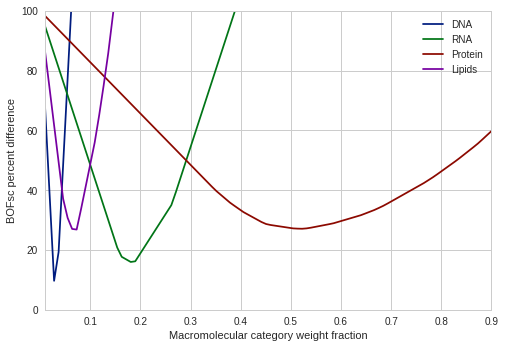

In [33]:
#Plot
color_palette = sb.color_palette('dark',10)
colors =  [color_palette[int(i)] for i in np.linspace(0,9, num=9)]
#Change column names
new_cols_dict =  {'dna':'DNA','rna':'RNA','protein':'Protein','lipids':'Lipids'}
ploting_df.rename(columns=new_cols_dict,inplace=True)
ax = ploting_df.plot(color=colors)
# zoom-in / limit the view to different portions of the data
ax.set_ylim(0., 100.)  # outliers only
plt.ylabel('BOFsc percent difference')
plt.xlabel('Macromolecular category weight fraction')
plt.savefig('/home/jean-christophe/Documents/Maitrise_UCSD/biomass/Paper_figures/supp2a.svg')
plt.show()

In [34]:
DNA_RATIO = 0.031
RNA_RATIO = 0.205
PROTEIN_RATIO = 0.55
LIPID_RATIO = 0.091
METABOLITE_RATIO = 0.1
iML_ratios = [DNA_RATIO,RNA_RATIO,PROTEIN_RATIO,LIPID_RATIO]
sum(iML_ratios)

0.877

In [41]:
import matplotlib.

ImportError: No module named rcParams

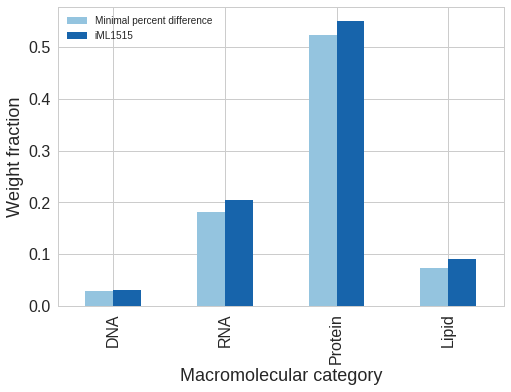

In [47]:
min_error, weight_fraction_min = [],[]
for col in ploting_df.columns:
    min_error.append(ploting_df[col].min())
    weight_fraction_min.append(ploting_df[col].idxmin())

result_df = pd.DataFrame({'Minimal percent difference':weight_fraction_min,'iML1515':[i for i in iML_ratios]},index=['DNA','RNA','Protein','Lipid'])
color_palette =  sb.color_palette('Blues',4)
result_df.plot(kind='bar',color=[color_palette[1],color_palette[3]],fontsize=16,)
plt.xlabel('Macromolecular category',fontsize=18)
plt.ylabel('Weight fraction',fontsize=18)

plt.savefig('/home/jean-christophe/Documents/Maitrise_UCSD/biomass/Paper_figures/supp2b.svg')
plt.show()

In [46]:
result_df.plot.bar?

In [33]:
lipid_coeff = bd.lipid.generate_coefficients(lipidomic_abundances,lipidomic_conversion,model)

In [34]:
lipid_coeff

{<Metabolite pg181_p at 0x7fbedcaaf250>: 0.023414170526528187,
 <Metabolite pe160_p at 0x7fbee1bfaed0>: 0.02729814520503996,
 <Metabolite pg160_p at 0x7fbee290a490>: 0.026517271162353293,
 <Metabolite pe181_p at 0x7fbee290ac10>: 0.014803692741437937,
 <Metabolite pe161_p at 0x7fbee354ba50>: 0.01805186677482472,
 <Metabolite pg161_p at 0x7fbee3815cd0>: 0.015893047536580777}

In [7]:
import cobra
import BOFdat
import pandas as pd
from cobra.util.solver import linear_reaction_coefficients
ecoli = cobra.io.load_json_model('iML1515.json')

In [18]:
[m.id for m in ecoli.reactions.Ec_biomass_iML1515_WT_75p37M.reactants if m.id.startswith('pg') or m.id.startswith('pe')]

[u'pg181_p', u'pe161_p', u'pg160_p', u'pe181_p', u'pg161_p', u'pe160_p']

In [11]:
biomass = ecoli.reactions.
for m in biomass.reactants:
    if m.id.startswith('pe') or m.id.startswith('pg'):
        print(m.id)


pe161_p
pe160_p


In [36]:
[i.formula_weight for i in lipid_coeff.keys()]

[744.0336809999999,
 774.036481,
 721.9619210000001,
 691.959121,
 717.930161,
 687.9273609999999]

In [14]:
import BOFdat
lipid_df = BOFdat.lipid.filter_for_model_metab('lipidomic_conversion.csv','iML1515.json')

In [15]:
lipid_df

,lipid_name,lipid_id
0,PE(16:0-cy17:0)/PE(15:0-18:1),pe160_p
1,PG(15:0-16:1)/PG(14:0-cy17:0),pg161_p
2,PE(15:0-16:1)/PE(14:0-cy17:0),pe161_p
3,PE(16:0-16:1)/PE(14:0-18:1),pe160_p
4,PG(16:0-cy19:0),pg160_p
5,PE(15:0-16:0),pe160_p
6,PE(18:1-18:1),pe181_p
7,PE(14:0-16:1),pe161_p
8,PE(17:0-18:1)/PE(16:0-cy19:0),pe181_p
9,PE(32:2) PE(16:1-16:1),pe161_p


In [6]:
from cobra.util.solver import linear_reaction_coefficients
biomass = linear_reaction_coefficients(ecoli).keys()[0]
for m in biomass.reactants:
    print(m.id)

NameError: name 'ecoli' is not defined

# Figure S3

,Uniprot Accession,Description,Gene,Peptides.used.for.quantitation,Confidence.score,Molecular weight (Da),Dataset,Glucose,LB,Glycerol + AA,...,Xylose.2,Mannose.2,Galactose .2,Succinate.2,Fructose.2,Gene.1,Bnumber,Annotated functional COG groups (letter),Annotated functional COG group (description),Annotated functional COG class
0,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=E...,rpoC,91,6045.53,155045.00800,2,2779,7164,4503.0,...,6.27,16.15,22.87,16.45,9.29,rpoC,b3988,K,Transcription,INFORMATION STORAGE AND PROCESSING
1,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Es...,rpoB,89,5061.29,150520.27580,2,3957,8888,5199.0,...,4.27,13.51,19.75,13.60,7.77,rpoB,b3987,K,Transcription,INFORMATION STORAGE AND PROCESSING
2,P36683,Aconitate hydratase 2 OS=Escherichia coli (str...,acnB,67,4505.67,93420.94570,2,7596,16600,17548.0,...,21.78,3.16,2.07,4.21,3.25,acnB,b0118,C,Energy production and conversion,METABOLISM
3,P15254,Phosphoribosylformylglycinamidine synthase OS=...,purL,65,4277.71,141295.89840,2,2456,821,2339.0,...,7.88,1.22,7.69,2.96,6.20,purL,b2557,F,Nucleotide transport and metabolism,METABOLISM
4,P09831,Glutamate synthase [NADPH] large chain OS=Esch...,gltB,64,4111.74,163176.31530,2,2859,604,652.0,...,20.05,17.71,22.36,10.69,8.91,gltB,b3212,E,Amino acid transport and metabolism,METABOLISM
5,P0AFG8,Pyruvate dehydrogenase E1 component OS=Escheri...,aceE,59,3547.25,99587.94042,2,5815,11820,6671.0,...,7.27,13.71,20.08,6.64,13.13,aceE,b0114,C,Energy production and conversion,METABOLISM
6,P0A9Q7,Aldehyde-alcohol dehydrogenase OS=Escherichia ...,adhE,58,4443.68,96048.64958,2,4851,5472,5634.0,...,3.19,18.77,20.21,29.64,6.36,adhE,b1241,C,Energy production and conversion,METABOLISM
7,P0CE47,Elongation factor Tu 1 OS=Escherichia coli (st...,tufA,57,4565.07,43238.30279,2,252452,443852,368888.0,...,0.71,2.96,3.21,3.92,3.95,tufA,b3339,J,"Translation, ribosomal structure and biogenesis",INFORMATION STORAGE AND PROCESSING
8,P25665,5-methyltetrahydropteroyltriglutamate--homocys...,metE,56,4067.16,84602.80905,2,51584,1711,1690.0,...,1.05,5.26,16.24,14.80,3.17,metE,b3829,E,Amino acid transport and metabolism,METABOLISM
9,P0A6F5,60 kDa chaperonin OS=Escherichia coli (strain ...,groL,55,3795.21,57274.67483,2,22739,65887,57319.0,...,7.86,3.16,3.13,6.32,1.36,groL,b4143,O,"Posttranslational modification, protein turnov...",CELLULAR PROCESSES AND SIGNALING


# Figure S3